In [1]:
import shap
import pandas as pd
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from alibi.explainers import AnchorTabular
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.feature_selection import SelectFromModel

/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-11 18:38:43.013067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
failures = pd.read_csv('../data/model_data/failures.csv',sep=',')
components = failures['component'].unique()

In [4]:
encoder = LabelEncoder()
for component in components:
    globals()[f"{component}_df"] = pd.read_csv(f'../data/model_data/labelled_data_{component}.csv',sep=',')
    globals()[f"{component}_df"]['turbine_id'] = encoder.fit_transform(['turbine_id']*globals()[f"{component}_df"].shape[0])
    # set the date as the index
    globals()[f"{component}_df"] = globals()[f"{component}_df"].set_index('timestamp')

In [5]:
class_target_name = "target_class"
for component in components:
    X = globals()[f"{component}_df"].drop(columns=['component',class_target_name])
    y = globals()[f"{component}_df"][class_target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    globals()[f"{component}_X_train"] = X_train
    globals()[f"{component}_X_test"] = X_test
    globals()[f"{component}_y_train"] = y_train
    globals()[f"{component}_y_test"] = y_test

In [6]:
model_name = "xgb"

In [8]:
for component in components:
    with open ('../models/selected-{}.pickle'.format(component), 'rb') as file:
        globals()[f"{model_name}_{component}"] = pickle.load(file)


In [9]:
for component in components:
    globals()[f"{model_name}_{component}"].fit(globals()[f"{component}_X_train"], globals()[f"{component}_y_train"])
    globals()[f"{component}_params"] = globals()[f"{model_name}_{component}"].get_params()
    globals()[f"{component}_selector"] = SelectFromModel(globals()[f"{model_name}_{component}"], threshold=-np.inf, prefit=True, max_features=globals()[f"{component}_params"]['max_features'])
    globals()[f"{component}_selected_features"] = globals()[f"{component}_X_train"].columns[globals()[f"{component}_selector"].get_support()]
    globals()[f"{component}_selected_features_train"] = globals()[f"{component}_X_train"][globals()[f"{component}_selected_features"]]
    globals()[f"{component}_selected_features_test"] = globals()[f"{component}_X_test"][globals()[f"{component}_selected_features"]]
    globals()[f"{component}_selected_features_train"].reset_index(drop=True, inplace=True)
    globals()[f"{component}_selected_features_test"].reset_index(drop=True, inplace=True)

    globals()[f"{model_name}_{component}"].fit(globals()[f"{component}_selected_features_train"], globals()[f"{component}_y_train"])

In [10]:
for component in components:
    globals()[f"{component}_explainer"] = shap.TreeExplainer(globals()[f"{model_name}_{component}"])
    globals()[f"{component}_shap_values"] = globals()[f"{component}_explainer"].shap_values(globals()[f"{component}_selected_features_test"])

In [11]:
shap.initjs()
shap.force_plot(GENERATOR_BEARING_explainer.expected_value, GENERATOR_BEARING_shap_values[0,:], GENERATOR_BEARING_selected_features_test.iloc[0,:])

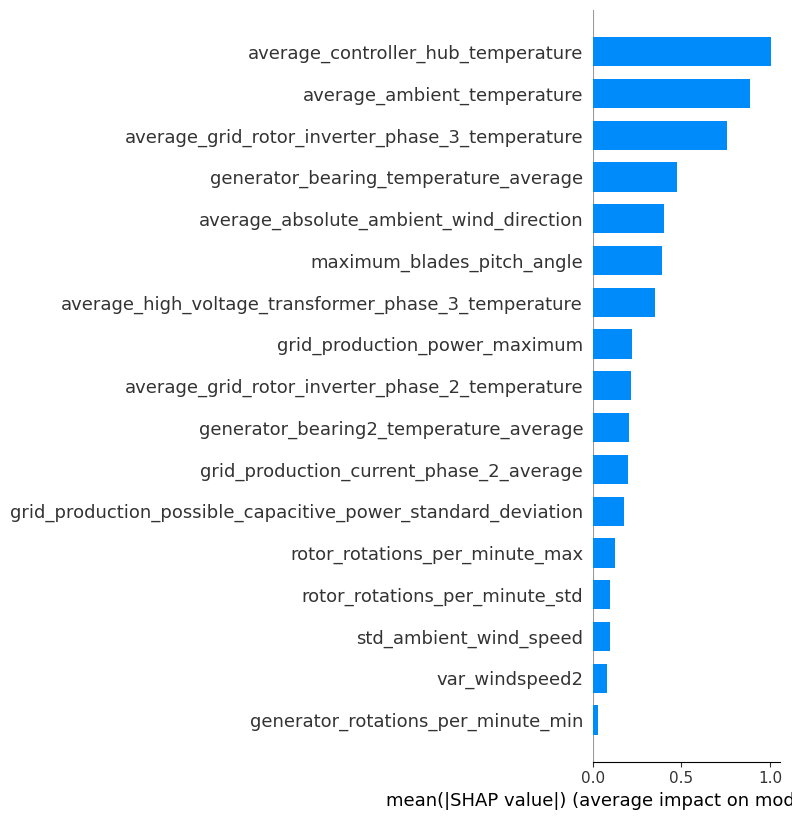

In [13]:
shap.summary_plot(GEARBOX_shap_values, GEARBOX_selected_features_test, plot_type="bar")

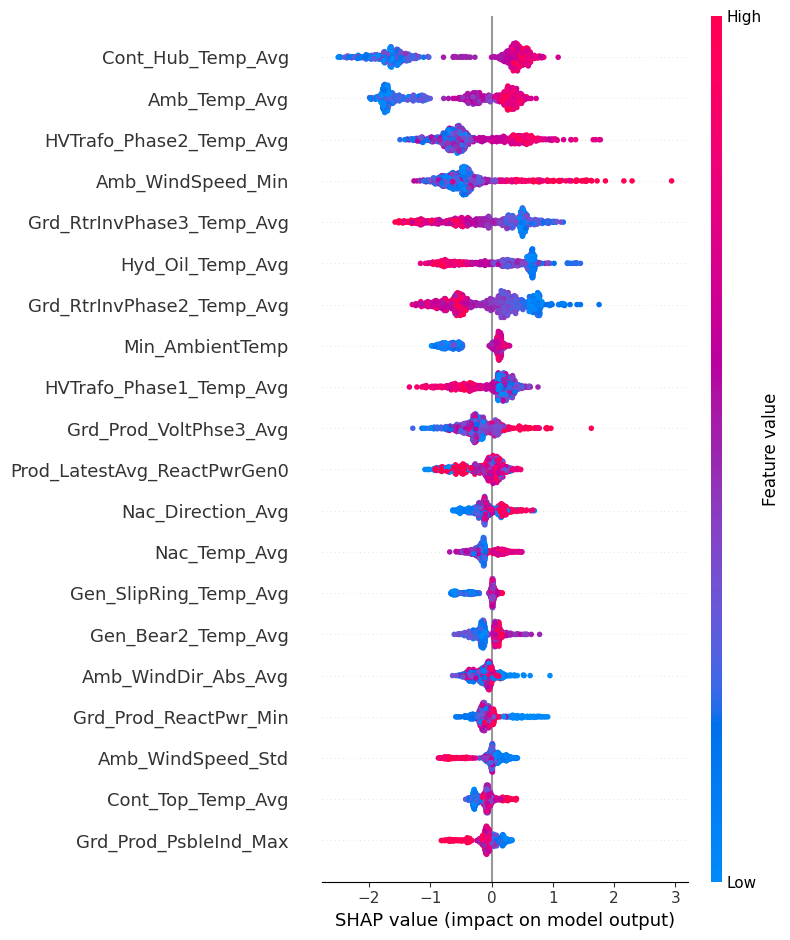

In [19]:
shap.summary_plot(shap_values, GEARBOX_selected_features_test)

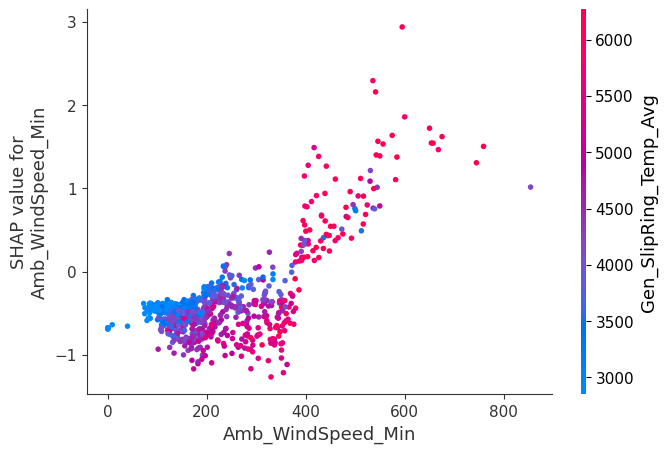

In [22]:
shap.dependence_plot("Amb_WindSpeed_Min", shap_values, GEARBOX_selected_features_test)

In [25]:
classes = xgb_GEARBOX.classes_.tolist()

In [60]:
# print all the shaplye value for each feature for each class
for i in range(len(classes)):
    for j in range(len(GENERATOR_BEARING_selected_features_test.columns)):
        print(f"Feature: {GENERATOR_BEARING_selected_features_test.columns[j]}")
        #print(f"shap_values: {shap_values[:,j]}")
        # sum of shapley values
        print(f"sum: {GENERATOR_BEARING_shap_values[:,j].sum()}")
        print("\n")


Feature: Gen_Phase3_Temp_Avg
sum: -0.9081423878669739


Feature: Hyd_Oil_Temp_Avg
sum: -20.824600219726562


Feature: Nac_Temp_Avg
sum: -4.160091876983643


Feature: Rtr_RPM_Max
sum: 0.5145279765129089


Feature: Amb_Temp_Avg
sum: -15.62076473236084


Feature: Prod_LatestAvg_ReactPwrGen0
sum: -17.651071548461914


Feature: HVTrafo_Phase1_Temp_Avg
sum: -68.7464599609375


Feature: HVTrafo_Phase2_Temp_Avg
sum: -4.229714393615723


Feature: HVTrafo_Phase3_Temp_Avg
sum: -176.2757568359375


Feature: Grd_InverterPhase1_Temp_Avg
sum: -7.09747838973999


Feature: Cont_VCP_Temp_Avg
sum: -0.2749750316143036


Feature: Cont_VCP_WtrTemp_Avg
sum: -4.454200744628906


Feature: Grd_Prod_VoltPhse1_Avg
sum: -72.30502319335938


Feature: Grd_Prod_VoltPhse2_Avg
sum: -19.371564865112305


Feature: Grd_Prod_VoltPhse3_Avg
sum: -24.776123046875


Feature: Grd_Prod_CurPhse1_Avg
sum: -2.1457021236419678


Feature: Grd_Busbar_Temp_Avg
sum: -3.2035393714904785


Feature: Gen_Bear2_Temp_Avg
sum: -22.565483093261